<a href="https://colab.research.google.com/github/pabair/ki-lab/blob/master/0_Simple_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Simple Neural Network with PyTorch. Original source can be found [here](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html).

In [ ]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2021-03-26 11:22:13--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-03-26 11:22:14--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.3’

MNIST.tar.gz.3          [        <=>         ]  33.20M  6.41MB/s    in 6.4s    

2021-03-26 11:22:21 (5.16 MB/s) - ‘MNIST.tar.gz.3’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw

In [ ]:
def nn_train(gpu = False, loss_function = "negative_loss_likelihood", size_hidden_layer = 100, learningrate=1e-4, n_epochs = 50):

  batch_size_train = 64
  batch_size_test = 1000
  momentum = 0.5

  random_seed = 1
  torch.backends.cudnn.enabled = False
  torch.manual_seed(random_seed)
  if gpu is True:
    device = "cuda" if torch.cuda.is_available() else "cpu"
  else:
    device = "cpu"
  
  print(device)

  #For local execution change number of workers to one
  kwargs = {'num_workers': 2, 'pin_memory': True} if device=='cuda' else {}

  transformer = T.Compose(
      [T.ToTensor(),
      T.Normalize((0.1307,), (0.3081,)),
      T.Lambda(lambda x: torch.flatten(x))
      ])

  train_loader = torch.utils.data.DataLoader(   
    torchvision.datasets.MNIST('/content/', 
                              train=True, 
                              download=True,
                              transform=transformer),  
                              batch_size=batch_size_train, 
                              shuffle=True, 
                              **kwargs)

  test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/content/', 
                              train=False, 
                              download=True,
                              transform=transformer),  
                              batch_size=batch_size_test, 
                              shuffle=True, 
                              **kwargs)

  examples = enumerate(test_loader)
  batch_idx, (example_data, example_targets) = next(examples)
  print(example_data.shape)

  class Net(nn.Module):
      def __init__(self, D_in, H, D_out, loss_function):
          super(Net, self).__init__()
          self.linear1 = nn.Linear(D_in, H)
          self.linear2 = nn.Linear(H, D_out)

      def forward(self, x):
              """
              In the forward function we accept a Tensor of input data and we must return
              a Tensor of output data. We can use Modules defined in the constructor as
              well as arbitrary operators on Tensors.
              """
              h_relu = self.linear1(x).clamp(min=0) #aka relu
              y_pred = self.linear2(h_relu)
              if loss_function is "cross_entropy":
                return y_pred
              else:#negative log likelihood 
                y_out = F.log_softmax(y_pred)
                return y_out
              
              
  def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if gpu:
          data = data.cuda()
          target = target.cuda()

        optimizer.zero_grad()
        y_pred = model(data)
        loss = criterion(y_pred, target)

        

        
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        train_counter.append(
          (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

        torch.save(model.state_dict(), '/model.pth')
        torch.save(optimizer.state_dict(), '/optimizer.pth')
    
    print(f"Loss in epoch {epoch}, last batch is {loss.item()}")   
    #print(f"Training finished for epoch {epoch}")

  def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
      for data, target in test_loader:
        if gpu:
          data = data.cuda()
          target = target.cuda()
        output = model(data)

        if loss_function is "cross_entropy":
          test_loss += F.cross_entropy(output, target, size_average=False).item()
        else:
          test_loss += F.nll_loss(output, target, size_average=False).item()

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
        
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('Test set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))
  
  batch_size, D_in, H, D_out = 64, (28 * 28) , size_hidden_layer, 10
  model = Net(D_in, H, D_out, loss_function)
  if gpu: 
    model.cuda()
  
  if loss_function is "cross_entropy":
    criterion = torch.nn.CrossEntropyLoss()
  else: #negative log likelihood
    criterion = torch.nn.NLLLoss()
  
  optimizer = torch.optim.SGD(model.parameters(), lr=learningrate, momentum=momentum)

  train_losses = []
  train_counter = []
  test_losses = []
  test_counter = [i*len(train_loader.dataset) for i in range(n_epochs)]

  training_time = 0.
  test()
  for epoch in range(1, n_epochs + 1):
    start = time.perf_counter()
    train(epoch)
    end = time.perf_counter()
    training_time += (end-start)
    test()

  print(f"Training time in seconds: {training_time}\n ~Training time in minutes: {round(training_time/60., 2)}")
  fig = plt.figure()
  plt.plot(train_counter, train_losses, color='blue')
  plt.legend(['Train Loss'], loc='upper right')
  plt.xlabel('number of training examples seen')
  plt.ylabel('negative log likelihood loss')

cpu
torch.Size([1000, 784])
Test set: Avg. loss: 2.3409, Accuracy: 1008/10000 (10%)

Loss in epoch 1, last batch is 1.9789929389953613
Test set: Avg. loss: 2.0213, Accuracy: 4808/10000 (48%)

Loss in epoch 2, last batch is 1.7200974225997925
Test set: Avg. loss: 1.7115, Accuracy: 6859/10000 (69%)

Loss in epoch 3, last batch is 1.3934545516967773
Test set: Avg. loss: 1.4249, Accuracy: 7562/10000 (76%)

Loss in epoch 4, last batch is 1.4039264917373657
Test set: Avg. loss: 1.1930, Accuracy: 7915/10000 (79%)

Loss in epoch 5, last batch is 1.1083928346633911
Test set: Avg. loss: 1.0197, Accuracy: 8126/10000 (81%)

Loss in epoch 6, last batch is 1.0246376991271973
Test set: Avg. loss: 0.8931, Accuracy: 8277/10000 (83%)

Loss in epoch 7, last batch is 0.8655585646629333
Test set: Avg. loss: 0.7995, Accuracy: 8388/10000 (84%)

Loss in epoch 8, last batch is 0.7308459877967834
Test set: Avg. loss: 0.7286, Accuracy: 8488/10000 (85%)

Loss in epoch 9, last batch is 0.9173921346664429
Test set:

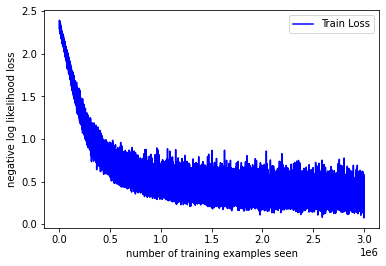

In [ ]:
# def nn_train(gpu, loss_function, size_hidden_layer = 100, learningrate=1e-4):

nn_train(False, "negative_loss_lokelihood", size_hidden_layer = 100, learningrate=1e-4)

cuda
torch.Size([1000, 784])
Test set: Avg. loss: 2.3409, Accuracy: 1008/10000 (10%)

Loss in epoch 1, last batch is 1.9789929389953613
Test set: Avg. loss: 2.0213, Accuracy: 4808/10000 (48%)

Loss in epoch 2, last batch is 1.7200974225997925
Test set: Avg. loss: 1.7115, Accuracy: 6859/10000 (69%)

Loss in epoch 3, last batch is 1.3934545516967773
Test set: Avg. loss: 1.4249, Accuracy: 7562/10000 (76%)

Loss in epoch 4, last batch is 1.4039267301559448
Test set: Avg. loss: 1.1930, Accuracy: 7915/10000 (79%)

Loss in epoch 5, last batch is 1.1083929538726807
Test set: Avg. loss: 1.0197, Accuracy: 8126/10000 (81%)

Loss in epoch 6, last batch is 1.0246378183364868
Test set: Avg. loss: 0.8931, Accuracy: 8277/10000 (83%)

Loss in epoch 7, last batch is 0.8655588030815125
Test set: Avg. loss: 0.7995, Accuracy: 8388/10000 (84%)

Loss in epoch 8, last batch is 0.7308459877967834
Test set: Avg. loss: 0.7286, Accuracy: 8488/10000 (85%)

Loss in epoch 9, last batch is 0.9173920154571533
Test set

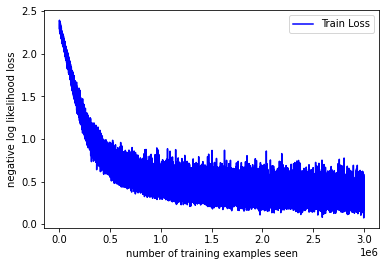

In [ ]:
nn_train(True, "negative_loss_loglikelihood", size_hidden_layer = 100, learningrate=1e-4)

cpu
torch.Size([1000, 784])
Test set: Avg. loss: 2.3409, Accuracy: 1008/10000 (10%)

Loss in epoch 1, last batch is 1.9789929389953613
Test set: Avg. loss: 2.0213, Accuracy: 4808/10000 (48%)

Loss in epoch 2, last batch is 1.7200974225997925
Test set: Avg. loss: 1.7115, Accuracy: 6859/10000 (69%)

Loss in epoch 3, last batch is 1.3934545516967773
Test set: Avg. loss: 1.4249, Accuracy: 7562/10000 (76%)

Loss in epoch 4, last batch is 1.4039264917373657
Test set: Avg. loss: 1.1930, Accuracy: 7915/10000 (79%)

Loss in epoch 5, last batch is 1.1083928346633911
Test set: Avg. loss: 1.0197, Accuracy: 8126/10000 (81%)

Loss in epoch 6, last batch is 1.0246376991271973
Test set: Avg. loss: 0.8931, Accuracy: 8277/10000 (83%)

Loss in epoch 7, last batch is 0.8655585646629333
Test set: Avg. loss: 0.7995, Accuracy: 8388/10000 (84%)

Loss in epoch 8, last batch is 0.7308459877967834
Test set: Avg. loss: 0.7286, Accuracy: 8488/10000 (85%)

Loss in epoch 9, last batch is 0.9173921346664429
Test set:

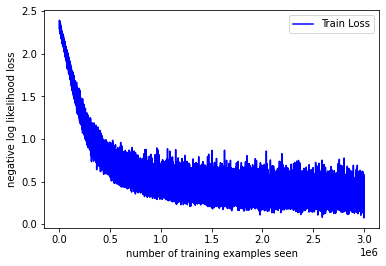

In [ ]:
nn_train(False, "cross_entropy", size_hidden_layer = 100, learningrate=1e-4)

cuda
torch.Size([1000, 784])
Test set: Avg. loss: 2.3409, Accuracy: 1008/10000 (10%)

Loss in epoch 1, last batch is 1.9789929389953613
Test set: Avg. loss: 2.0213, Accuracy: 4808/10000 (48%)

Loss in epoch 2, last batch is 1.7200974225997925
Test set: Avg. loss: 1.7115, Accuracy: 6859/10000 (69%)

Loss in epoch 3, last batch is 1.3934545516967773
Test set: Avg. loss: 1.4249, Accuracy: 7562/10000 (76%)

Loss in epoch 4, last batch is 1.4039267301559448
Test set: Avg. loss: 1.1930, Accuracy: 7915/10000 (79%)

Loss in epoch 5, last batch is 1.1083929538726807
Test set: Avg. loss: 1.0197, Accuracy: 8126/10000 (81%)

Loss in epoch 6, last batch is 1.0246378183364868
Test set: Avg. loss: 0.8931, Accuracy: 8277/10000 (83%)

Loss in epoch 7, last batch is 0.8655588030815125
Test set: Avg. loss: 0.7995, Accuracy: 8388/10000 (84%)

Loss in epoch 8, last batch is 0.7308459877967834
Test set: Avg. loss: 0.7286, Accuracy: 8488/10000 (85%)

Loss in epoch 9, last batch is 0.9173920154571533
Test set

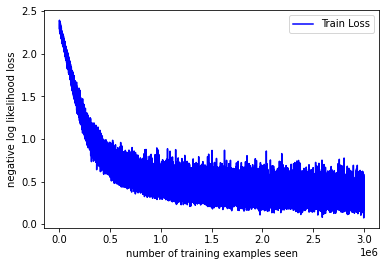

In [ ]:
nn_train(True, "cross_entropy", size_hidden_layer = 100, learningrate=1e-4)

cuda
torch.Size([1000, 784])
Test set: Avg. loss: 2.3462, Accuracy: 669/10000 (7%)

Loss in epoch 1, last batch is 2.083897352218628
Test set: Avg. loss: 2.0215, Accuracy: 5173/10000 (52%)

Loss in epoch 2, last batch is 1.7099701166152954
Test set: Avg. loss: 1.7162, Accuracy: 6790/10000 (68%)

Loss in epoch 3, last batch is 1.4242075681686401
Test set: Avg. loss: 1.4306, Accuracy: 7363/10000 (74%)

Loss in epoch 4, last batch is 1.2861266136169434
Test set: Avg. loss: 1.1961, Accuracy: 7709/10000 (77%)

Loss in epoch 5, last batch is 0.9967806935310364
Test set: Avg. loss: 1.0199, Accuracy: 7977/10000 (80%)

Loss in epoch 6, last batch is 0.8601081967353821
Test set: Avg. loss: 0.8909, Accuracy: 8188/10000 (82%)

Loss in epoch 7, last batch is 0.8643434047698975
Test set: Avg. loss: 0.7956, Accuracy: 8328/10000 (83%)

Loss in epoch 8, last batch is 0.6671380996704102
Test set: Avg. loss: 0.7237, Accuracy: 8434/10000 (84%)

Loss in epoch 9, last batch is 0.5496865510940552
Test set: A

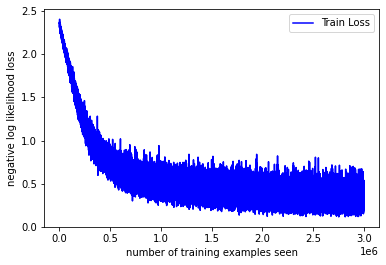

In [ ]:
nn_train(True, "loss_likelihood", size_hidden_layer = 200, learningrate=1e-4)

cuda
torch.Size([1000, 784])
Test set: Avg. loss: 2.3256, Accuracy: 936/10000 (9%)

Loss in epoch 1, last batch is 2.0170202255249023
Test set: Avg. loss: 2.0061, Accuracy: 4204/10000 (42%)

Loss in epoch 2, last batch is 1.8050881624221802
Test set: Avg. loss: 1.7043, Accuracy: 6397/10000 (64%)

Loss in epoch 3, last batch is 1.4472732543945312
Test set: Avg. loss: 1.4307, Accuracy: 7332/10000 (73%)

Loss in epoch 4, last batch is 1.2858400344848633
Test set: Avg. loss: 1.2118, Accuracy: 7669/10000 (77%)

Loss in epoch 5, last batch is 1.1144509315490723
Test set: Avg. loss: 1.0470, Accuracy: 7912/10000 (79%)

Loss in epoch 6, last batch is 0.9859715104103088
Test set: Avg. loss: 0.9248, Accuracy: 8100/10000 (81%)

Loss in epoch 7, last batch is 0.8126939535140991
Test set: Avg. loss: 0.8327, Accuracy: 8261/10000 (83%)

Loss in epoch 8, last batch is 0.9682960510253906
Test set: Avg. loss: 0.7615, Accuracy: 8378/10000 (84%)

Loss in epoch 9, last batch is 0.6681110858917236
Test set: 

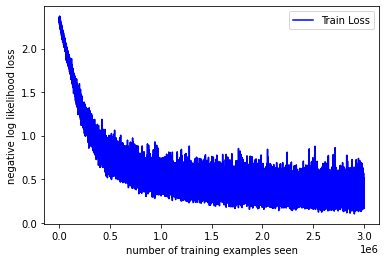

In [ ]:
nn_train(True, "loss_likelihood", size_hidden_layer = 50, learningrate=1e-4)